In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime, timedelta
import warnings

from sklearn.linear_model import LinearRegression
import yfinance as yf

[*********************100%%**********************]  1 of 1 completed


Linear Regression model
VFH ETF Price (y) = 1.22 * 3 Days Moving Average (x1)     + -0.23 * 9 Days Moving Average (x2)     + 0.17 (constant)


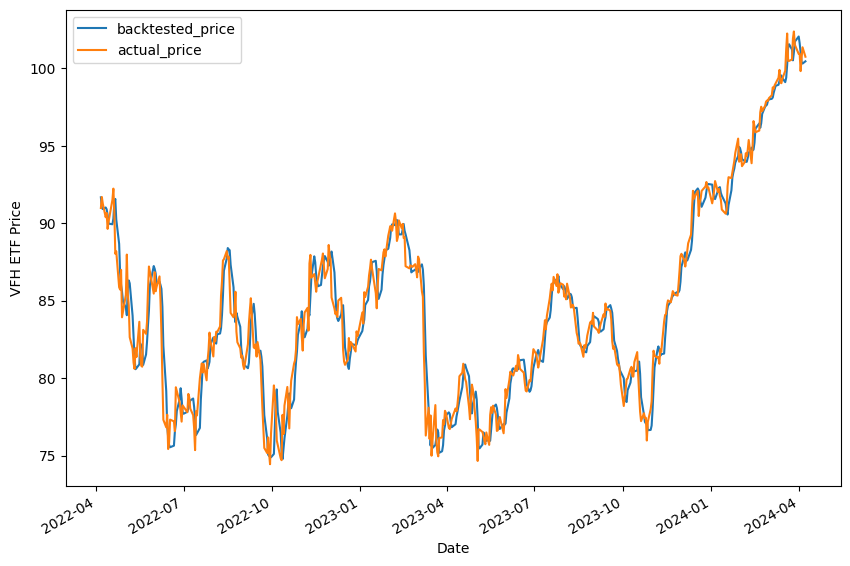

[*********************100%%**********************]  1 of 1 completed

                 price
Date                  
2022-04-06   91.678057
2022-04-07   90.990327
2022-04-08   90.921757
2022-04-11   91.022690
2022-04-12   90.905526
...                ...
2024-04-02  101.635724
2024-04-03  101.059940
2024-04-04  100.427663
2024-04-05  100.316895
2024-04-08  100.462026

[503 rows x 1 columns]
                 Close         S_3         S_9
Date                                          
2019-05-13   66.830002   68.083333   69.007778
2019-05-14   67.480003   67.730001   68.786667
2019-05-15   67.180000   67.163335   68.512222
2019-05-16   67.849998   67.503334   68.242222
2019-05-17   67.440002   67.490000   67.962223
...                ...         ...         ...
2024-04-03  100.959999  101.143333  101.285556
2024-04-04   99.830002  100.576668  101.015555
2024-04-05  100.680000  100.490000  101.036667
2024-04-08  101.370003  100.626668  101.134445
2024-04-09  100.760002  100.936668  101.154445

[1236 rows x 3 columns]
original df
                 Close       


[*********************100%%**********************]  1 of 1 completed


Linear Regression model
VTV ETF Price (y) = 1.20 * 3 Days Moving Average (x1)     + -0.21 * 9 Days Moving Average (x2)     + 0.16 (constant)


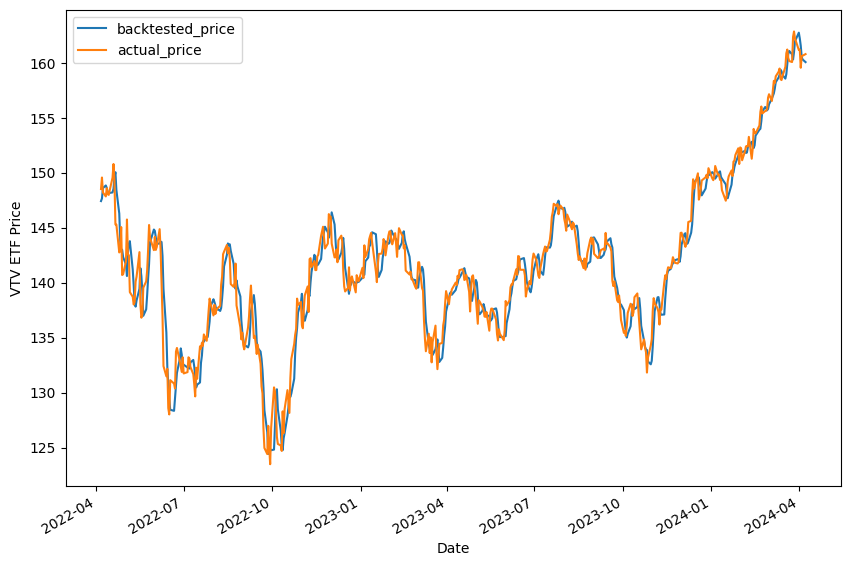

[*********************100%%**********************]  1 of 1 completed

                 price
Date                  
2022-04-06  147.426083
2022-04-07  147.668105
2022-04-08  148.608430
2022-04-11  148.846549
2022-04-12  148.625974
...                ...
2024-04-02  162.237861
2024-04-03  161.567953
2024-04-04  160.538008
2024-04-05  160.305538
2024-04-08  160.073559

[503 rows x 1 columns]
                 Close         S_3         S_9
Date                                          
2019-05-13  106.889999  108.133334  109.361112
2019-05-14  107.570000  107.843333  109.046667
2019-05-15  107.800003  107.420001  108.785556
2019-05-16  108.669998  108.013334  108.526667
2019-05-17  108.239998  108.236666  108.261112
...                ...         ...         ...
2024-04-03  161.210007  161.536667  161.306666
2024-04-04  159.559998  160.649999  161.122221
2024-04-05  160.610001  160.460002  161.139999
2024-04-08  160.660004  160.276667  161.194444
2024-04-09  160.800003  160.690002  161.274445

[1236 rows x 3 columns]
original df
                 Close       

In [8]:
# analyse VFH and VTV
products = ['VFH', 'VTV']
for product in products:
    df = yf.download(product, '2014-04-01', '2024-04-10')
    df = df[['Close']]
    df = df.dropna()
    # df.Close.plot(figsize=(10, 7),color='r')
    # plt.ylabel(f"{product} ETF Prices")
    # plt.title(f"{product} ETF Price Series")
    # plt.show()
    
    df['S_3'] = df['Close'].rolling(window=3).mean()
    df['S_9'] = df['Close'].rolling(window=9).mean()
    df['next_day_price'] = df['Close'].shift(-1)

    df = df.dropna()
    x = df[['S_3', 'S_9']]

    y = df['next_day_price']

    # separate testing and training data
    index = int(0.8*(len(df)))
    x_train, x_test, y_train, y_test = x[:index], x[index:], y[:index], y[index:]

    # train linear regression
    linear = LinearRegression().fit(x_train, y_train)

    print("Linear Regression model")
    print(f"{product} ETF Price (y) = %.2f * 3 Days Moving Average (x1) \
    + %.2f * 9 Days Moving Average (x2) \
    + %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))
    
    backtest_price = linear.predict(x_test)
    backtest_price = pd.DataFrame(
        backtest_price, index=y_test.index, columns=['price'])
    backtest_price.plot(figsize=(10, 7))
    y_test.plot()
    plt.legend(['backtested_price', 'actual_price'])
    plt.ylabel(f"{product} ETF Price")
    plt.show()

    print(backtest_price)
    # export to excel
    export_df = pd.DataFrame({
        'dates': x_test.index, 
        'actual_price': y_test,
        'backtested_price': backtest_price['price']  
    })

    # Export the DataFrame to an Excel file
    export_df.to_excel(f"{product}_backtest_results.xlsx", index=False)
    
    # predict next 3 months
    predict_df = yf.download(product, '2019-05-01', '2024-04-10')
    predict_df = predict_df[['Close']]
    predict_df = predict_df.dropna()
    predict_df['S_3'] = predict_df['Close'].rolling(window=3).mean()
    predict_df['S_9'] = predict_df['Close'].rolling(window=9).mean()
    predict_df = predict_df.dropna()
    print(predict_df)
    current_date = predict_df.index[-1]
    end_date = datetime(2024, 7, 31)

    print("original df")
    print(predict_df)
    while current_date <= end_date:
        # forecast the price
        predict_df['predicted_price'] = linear.predict(predict_df[['S_3', 'S_9']])
        last_row = predict_df.tail(1)
        predicted_nlr_price = last_row['predicted_price'].iloc[-1]
        # print("predicted price: ", predicted_nlr_price)
        # print("after calculating predicted price")
        # print(df)

        last_date = predict_df.index[-1]
        new_date = last_date + timedelta(days=1)
        current_date = new_date
        new_row = pd.DataFrame(index=[new_date], columns=predict_df.columns)
        new_row['Close'] = predicted_nlr_price
        moving_avg_list = predict_df['Close'].iloc[-8:].tolist()
        moving_avg_list.append(predicted_nlr_price)
        new_row['S_3'] = sum(moving_avg_list[-3:]) / 3
        new_row['S_9'] = sum(moving_avg_list) / 9
        warnings.filterwarnings("ignore", message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.*")
        predict_df = pd.concat([predict_df, new_row])   
        # print("after adding new row")
        # print(df)

    # adjust to only weekly data 
    predict_df = predict_df.resample('W-FRI').last() # only weekly data 
    # export to excel
    export_df = pd.DataFrame({
        'Dates': predict_df.index, 
        'Historical Price': predict_df['Close'], 
        'Base': predict_df['predicted_price'],
    })

    # Export the DataFrame to an Excel file
    export_df.to_excel(f"{product}_predicted_results.xlsx", index=False)